In [1]:
import pickle
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.estimator import DNNClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


### Load data

In [2]:
df = pd.read_csv("../data/mixed_data_1200.csv", sep=';')
df = df.drop(["Unnamed: 0"],axis=1)
df.head(5)

,target,text
0,0,@Starrbby too bad I won't be around I lost my ...
1,0,amazon s3 plugin not worked in my website . it...
2,0,The Hoyts Distribution NZ website isn't workin...
3,0,dang won't be able to get to any workshops run...
4,0,Tried to install a Twitter-application on my p...


In [3]:
#converts whitespaces
trb_nan_idx = df[pd.isnull(df['text'])].index.tolist()
df.loc[trb_nan_idx, 'text'] = ' '
X_load = df["text"]
Y_load = df["target"]

#Creation of a dictionary with #0 = negative to 0, 2 = neutral to 1, 4 = positive to 2
dicc = {0:0,2:1,4:2}
Y_load = Y_load.map(dicc)

### Convert Data to fit for softmax activation function

In [4]:
X_traink ,X_testk, y_traink, y_testk = train_test_split(X_load,Y_load,test_size=0.2,random_state=42,shuffle=True)
y_test = y_testk

tokenizer = Tokenizer(lower=True,filters = "!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n", split = " ")
tokenizer.fit_on_texts(X_traink)

### Convert Data to fit for softmax activation function

In [5]:
# integer encode documents // standard bag-of-words of length vocab size => len(t.word_index) = 7282
encoded_tweets = tokenizer.texts_to_matrix(X_load, mode='tfidf') #binary / count / tfidf / freq
X_traink = tokenizer.texts_to_matrix(X_traink, mode='tfidf') #binary / count / tfidf / freq
X_testk = tokenizer.texts_to_matrix(X_testk, mode='tfidf') 

In [6]:
encoded_tweets.shape

(3310, 6386)

In [7]:
vocab_size = len(encoded_tweets[0])
tweets_size = len(encoded_tweets)
print('The vocabulary includes {} unique words and {} tweets'.format(vocab_size,tweets_size))

The vocabulary includes 6386 unique words and 3310 tweets


### Convert Data to fit for softmax activation function

In [8]:
num_classes = max(y_traink+1)
print(num_classes)
y_traink = tf.keras.utils.to_categorical(y_traink,num_classes=3)
y_testk = tf.keras.utils.to_categorical(y_testk,num_classes=3)

3


In [9]:
X_traink.shape

(2648, 6386)

In [10]:
print(y_traink)
print(y_testk)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### Define Model

In [11]:
max_words = 6386

model = Sequential()
model.add(Dense(128,input_shape=(6386, )))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train

In [12]:
batch_size = 10
epochs = 5

history = model.fit(X_traink,y_traink,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)
scores = model.evaluate(X_testk,y_testk,batch_size=batch_size,verbose=1)

print("Accuracy is: {}".format(scores[1]))

W0706 08:49:47.278122 4462642624 deprecation.py:323] From /Users/ChrisChross/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2383 samples, validate on 265 samples
Epoch 1/5
2383/2383 [==============================] - 2s 999us/sample - loss: 0.4815 - accuracy: 0.8208 - val_loss: 0.2230 - val_accuracy: 0.9094
Epoch 2/5
2383/2383 [==============================] - 1s 613us/sample - loss: 0.0641 - accuracy: 0.9845 - val_loss: 0.2022 - val_accuracy: 0.9170
Epoch 3/5
2383/2383 [==============================] - 1s 582us/sample - loss: 0.0211 - accuracy: 0.9958 - val_loss: 0.1968 - val_accuracy: 0.9094
Epoch 4/5
2383/2383 [==============================] - 1s 591us/sample - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.2013 - val_accuracy: 0.9132
Epoch 5/5
662/662 [==============================] - 0s 300us/sample - loss: 0.2328 - accuracy: 0.9245
Accuracy is: 0.9244713187217712


In [13]:
# TF-IDF encoded Matrix of tweets
#dfidf_df = pd.DataFrame(data=encoded_tweets)
#dfidf_df
#dflatex1 = dfidf_df.iloc[[0,1,2,3,-3,-2,-1], [0,1,2,3,-3,-2,-1]]
#print(dflatex1.to_latex())

### Predict

In [14]:
predictions = model.predict_classes(X_testk)

In [15]:
xxx = ["Today my PC crashed what a shit I can not work I am so stressed"]
xxx1 =  tokenizer.texts_to_matrix(xxx)
#xxx2 = pad_sequences(xxx1,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)
pred = model.predict_classes(xxx1)
pred

array([0])

### Evaluate

In [22]:
print(metrics.classification_report(y_test, predictions,target_names=["technostress","neutral","positive"]))
report = metrics.classification_report(y_test, predictions,target_names=["technostress","neutral","positive"],output_dict=True)
reportdf = pd.DataFrame(report).transpose()
#print(reportdf.to_latex())


              precision    recall  f1-score   support

technostress       0.98      0.97      0.97       259
     neutral       0.89      0.94      0.91       216
    positive       0.89      0.86      0.87       187

   micro avg       0.92      0.92      0.92       662
   macro avg       0.92      0.92      0.92       662
weighted avg       0.93      0.92      0.92       662



<Figure size 432x288 with 0 Axes>

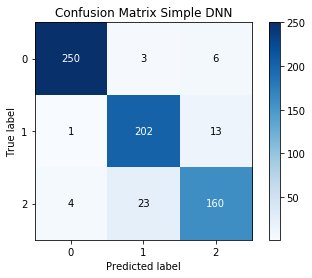

In [17]:
plt.figure()
skplt.metrics.plot_confusion_matrix(y_test,predictions,normalize=False)
plt.title("Confusion Matrix Simple DNN")
#cnf_matrix = metrics.confusion_matrix(y_test, predictions)
plt.show()

In [18]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


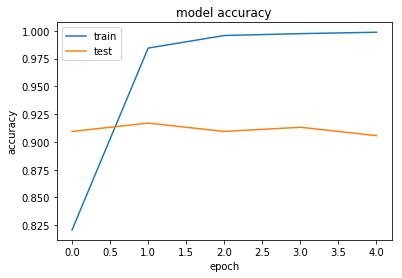

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

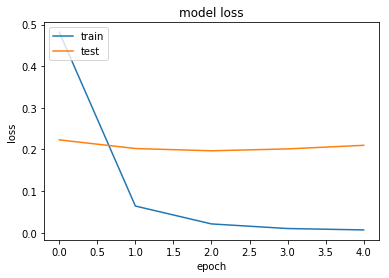

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()